This is a project presenting pricing Credit Default Swap(CDS) under assumptions of Reduced Form Model.

Methodology:
1) The value of the CDS is established as a net present value(NPV) of cashflows coming from protected leg and premium leg.
2) Daily treasury rates(10/02/2023 - 10/27/2023) obtained from U.S Departament of Treasury were used to construct a yield curve serving a source of discounting factors.
3) The default probabilities were derived from global corporate average cumulative default rates (1981-2022) associated with "BB" credit rating according to 
"Default, Transition, and Recovery: 2022 Annual Global Corporate Default And Rating Transition Study" by S&P Global.

https://www.spglobal.com/ratings/en/regulatory/article/230425-default-transition-and-recovery-2022-annual-global-corporate-default-and-rating-transition-study-s12702145

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline


In [33]:
# Example parameters of priced CDS
market_price = 70000      # Current matket value of priced CDS in $
notional = 1000000        # Notional amount in $
T = 5                     # Maturity of priced CDS in years
recovery_rate = 0.4       # Recovery rate 
spread = 150              # Fixed CDS spread paid as premium in basis points
delta = 20                # parameter  allowing to check results sensitivity to yield curve change 


In [34]:
# Establishing yield curve based on  treasury rates for various maturities
treasury_data = pd.read_csv('daily-treasury-rates.csv')

maturities=[]      #list of maturities with assigned interst rates
for row in treasury_data:
    maturities.append(row)
maturities.remove('Date')

treasury_dates = pd.to_datetime(treasury_data['Date'])
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

num_rates=np.empty((len(treasury_dates), len(maturities)))       # list of numerical intrest rates 
num_mat=[]                                                       # list of maturities in numerical format

In [35]:
# Function to transfer intrest rates to an array
def transfer_to_array(treasury_dates, maturities, treasury_data, num_rates):
    i = 0
    for date in treasury_dates:
        j = 0
        for maturity in maturities:
            num_rates[i][j] = treasury_data[maturity][i]
            j+=1
        i+=1

transfer_to_array(treasury_dates, maturities, treasury_data, num_rates)

In [36]:
# Setting maturities to numerical format(the unit is year)
for maturity in maturities:
    num_mat.append(str(maturity))

for i in range(len(num_mat)):
    if 'Mo' in num_mat[i]:
        num_mat[i] = float(num_mat[i].replace(' Mo',''))/12
        continue
    if 'Yr' in num_mat[i]:
        num_mat[i] = float(num_mat[i].replace(' Yr',''))

In [37]:
# Building yield curve based on obtained interest rates
yield_curve_0 = CubicSpline(num_mat, num_rates[0,:], axis=0, extrapolate=None)

# Define yield curve scenarios 
num_rates_1 = [num_rates[0][i] + (delta / 1000) for i in range(0, len(maturities))]
num_rates_2 = [num_rates[0][i] - (delta / 1000) for i in range(0, len(maturities))]
yield_curve_1 = CubicSpline(num_mat, num_rates_1, axis=0, extrapolate=None)   # Shift the curve up by delta basis points
yield_curve_2 = CubicSpline(num_mat, num_rates_2, axis=0, extrapolate=None)   # Shift the curve down by delta basis points

# function to creeate yield curve for a given day 'j' shifted by a 'delta' basis points
def daily_yield_curve(num_rates, j, delta):
    num_rates_j = [num_rates[j][i] + (delta / 1000) for i in range(0, len(maturities))]
    yield_curve_j = CubicSpline(num_mat, num_rates_j, axis=0, extrapolate=None)
    return yield_curve_j


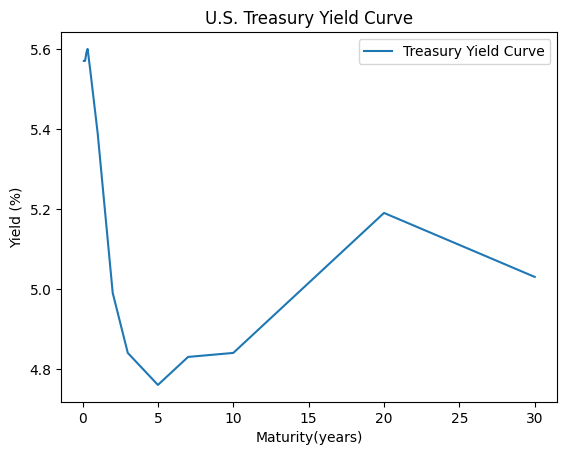

In [38]:
# Plotting obtained yield curve in a base scenario
plt.plot(num_mat, yield_curve_0(num_mat), label='Treasury Yield Curve')
plt.xlabel('Maturity(years)')
plt.ylabel('Yield (%)')
plt.title('U.S. Treasury Yield Curve')
plt.legend()
plt.show()

In [48]:
# Cumulative average default rates from S&P Global Ratings report for BB-rated entities. Cumulative_default_rates[i] := percentage of entities defaulted by year i + 1
cumulative_default_rates = [0.59, 1.84, 3.28, 4.70, 6.04, 7.27, 8.33, 9.31, 10.18, 10.94, 11.58, 12.19, 12.73, 13.18, 13.67]

# Convert percentages to decimals
cumulative_default_rates = [rate / 100 for rate in cumulative_default_rates]

In [49]:
# Function to calculate present value of the CDS
def cds_present_value_calculation(notional, spread, recovery_rate, cumulative_default_rates, time_horizon, yield_curve):
    
    cds_present_value = 0       # Present value of CDS that will be updated after evry period

    # Set discount rates according to yield curve
    r = [float(yield_curve(i))/100 for i in range(1, time_horizon + 1)]

    # Calculate discount factors for each period
    discount_factors = [(1 + r[i]) ** -(i + 1) for i in range(len(r))]

    for i in range(0, time_horizon):
       
        # Payments depending on survival probability 
        premium_leg_payment = notional * (spread/10000) * (1 - cumulative_default_rates[i])

        period_default_prob = cumulative_default_rates[i] if i == 0 else cumulative_default_rates[i] - cumulative_default_rates[i - 1]

        protection_leg_payment = -notional * (1-recovery_rate) * period_default_prob
        
        # Discounting payments
        pv_premium_leg_payment = premium_leg_payment * discount_factors[i]
        pv_protection_leg_payment = protection_leg_payment * discount_factors[i]

        cds_present_value += pv_premium_leg_payment + pv_protection_leg_payment
    
    return cds_present_value



In [50]:
# Function to calculate the implied spread given CDS market price
def calculate_implied_spread(cds_market_price, notional, recovery_rate, cumulative_default_rates, time_horizon, yield_curve):
    
    implied_spread = 0.0
    
    def spread_function(initial_guess):
        present_value = cds_present_value_calculation(notional, initial_guess, recovery_rate, cumulative_default_rates, time_horizon, yield_curve)
        return present_value - cds_market_price
    a=0.01
    b=1.0
    while spread_function(a) * spread_function(b) > 0:
        b=b+1 

    implied_spread = brentq(spread_function, a, b, maxiter=100)  # Use the specified initial guess range
    
    return implied_spread


In [51]:
# Function to calculate prices for different days with daily yield curve shifted by 'delta' basis points
def time_change_of_price(num_rates, notional, spread, recovery_rate, cumulative_default_rates, time_horizon, delta):
    price=[]
    for i in range (0, len(treasury_dates)):
        yield_curve_i = daily_yield_curve(num_rates, i, delta)
        price.append(cds_present_value_calculation(notional, spread, recovery_rate, cumulative_default_rates, time_horizon, yield_curve_i))
    
    return price

In [52]:
# Pricing
pv = cds_present_value_calculation(notional, spread, recovery_rate,  cumulative_default_rates, T, yield_curve_0)
#implied_spread = calculate_implied_spread(market_price, notional, recovery_rate,  credit_events, yield_curve_0)

# Calculate present values for each scenario
pv_scenario_1 = cds_present_value_calculation(notional, spread, recovery_rate,  cumulative_default_rates, T, yield_curve_1)
pv_scenario_2 = cds_present_value_calculation(notional, spread, recovery_rate,  cumulative_default_rates, T, yield_curve_2)

print(f"Present value in base sceanrio: {pv:.4f} $")
#print(f"Implied spread: {implied_spread:.4f}(in basis points) \n")
print(f"Present value in sceanrio 1(shift the curve up by {delta} basis points): {pv_scenario_1:.4f} $\n")
print(f"Present value in sceanrio 2(shift the curve down by {delta} basis points): {pv_scenario_2:.4f} $\n")


Present value in base sceanrio: 32024.5996 $
Present value in sceanrio 1(shift the curve up by 20 basis points): 32008.9096 $

Present value in sceanrio 2(shift the curve down by 20 basis points): 32040.3027 $



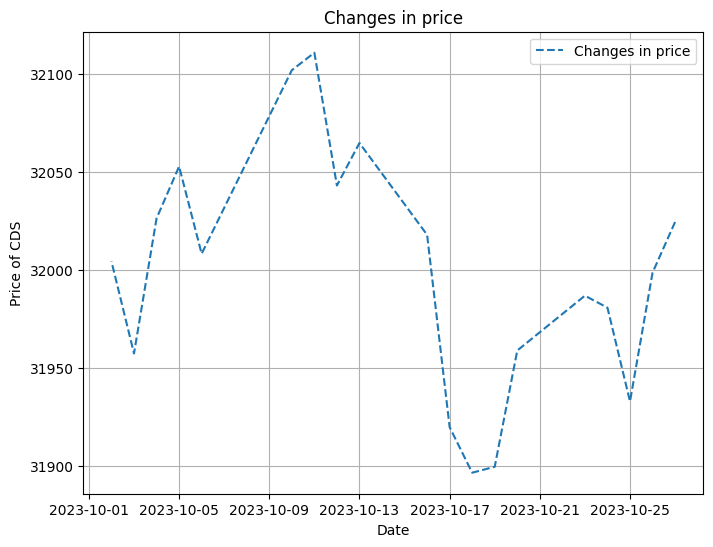

In [53]:
# Ploting change of price during considered timeframe (length of frame <<< period between payments),
# taking into consideration differences in yield curves 

plt.figure(figsize=(8, 6))
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, cumulative_default_rates, T,0), label='Changes in price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price of CDS')
plt.title('Changes in price')
plt.grid(True)
plt.legend()
plt.show()

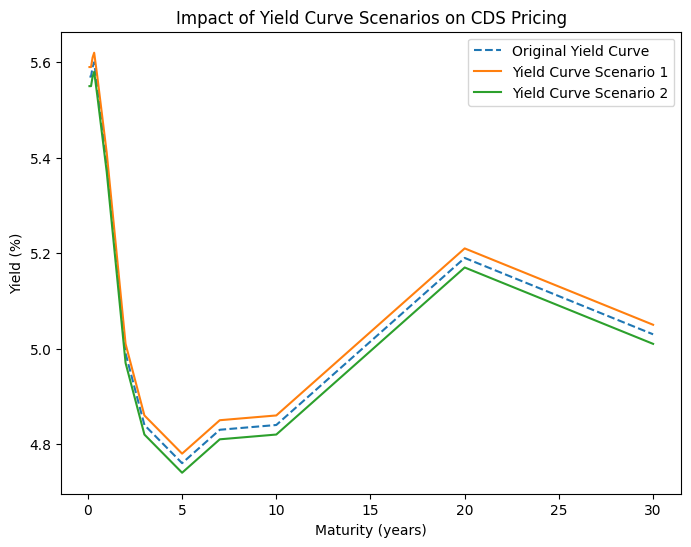

In [54]:
# The results of shifting yield curve
plt.figure(figsize=(8, 6))
plt.plot(num_mat, yield_curve_0(num_mat), label='Original Yield Curve', linestyle='--')
plt.plot(num_mat, yield_curve_1(num_mat), label='Yield Curve Scenario 1')
plt.plot(num_mat, yield_curve_2(num_mat), label='Yield Curve Scenario 2')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.title('Impact of Yield Curve Scenarios on CDS Pricing')
plt.legend()
plt.show()

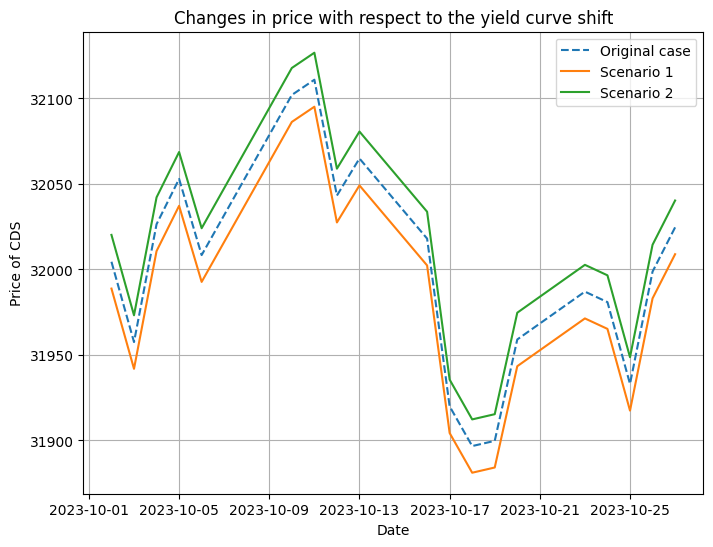

In [55]:
# Impact of shifting yield curve on CDS price

plt.figure(figsize=(8, 6))
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, cumulative_default_rates, T, 0), label='Original case', linestyle='--')
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, cumulative_default_rates, T, delta), label='Scenario 1')
plt.plot(treasury_dates, time_change_of_price(num_rates, notional, spread, recovery_rate, cumulative_default_rates, T, -delta), label='Scenario 2' )
plt.xlabel('Date')
plt.ylabel('Price of CDS')
plt.title('Changes in price with respect to the yield curve shift')
plt.grid(True)
plt.legend()
plt.show()